In [0]:
!mkdir /root/.kaggle
!mv kaggle.json /root/.kaggle/kaggle.json
!chmod 777 /root/.kaggle/kaggle.json
!kaggle competitions download -c nlp-getting-started

mkdir: cannot create directory ‘/root/.kaggle’: File exists
  0% 0.00/411k [00:00<?, ?B/s]
100% 411k/411k [00:00<00:00, 60.9MB/s]
  0% 0.00/965k [00:00<?, ?B/s]
100% 965k/965k [00:00<00:00, 58.7MB/s]
  0% 0.00/22.2k [00:00<?, ?B/s]
100% 22.2k/22.2k [00:00<00:00, 22.9MB/s]


In [0]:
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import numpy as np
import xgboost as xgb
import torch
import torch.nn as nn
import re
from nltk.tokenize import sent_tokenize, word_tokenize ,TweetTokenizer
import torch.optim as optimizers
from torch.utils.data import DataLoader,TensorDataset
!pip install tqdm
from tqdm import tqdm
warnings.simplefilter('ignore')
import nltk
nltk.download('punkt')
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler()
#辞書構造
class Vocabulary():
    def __init__(self,disabletokenize=False):
        self.w2i={}
        self.i2w={}
        self.oov_char='<unk>'
        self.pad='<pad>'
        self.bos='<bos>'
        self.eos='<eos>'

        self.special_chars = [self.pad,self.oov_char,self.bos,self.eos]
        self.data = ""
        self._words=set()
        self.tokenize=disabletokenize
        self.tknzr = TweetTokenizer()
    def update(self,text):
        if(self.tokenize):
            self._words.update(text)
        else:
            self.data=self.tknzr.tokenize(text)
            #self.data=word_tokenize(text)
            self._words.update(self.data)
        self.w2i = {w: (i + len(self.special_chars)) for i, w in enumerate(self._words)}

        self.i2w = {i: w for w, i in self.w2i.items()}
        self.w2i['<pad>'] = 0
        self.i2w[0] = '<pad>'
        self.w2i['<unk>'] = 1
        self.i2w[1] = '<unk>'
        self.w2i['<bos>'] = 2
        self.i2w[2] = '<bos>'
        self.w2i['<eos>'] = 3
        self.i2w[3] = '<eos>'


    def encode(self,words):
        output=[]
        if(self.tokenize):
            pass
        else:
            #words=word_tokenize(words)
            words=self.tknzr.tokenize(words)
        for word in words:
            #辞書になし
            if word not in self.w2i:
                index = self.w2i[self.oov_char]#既存の<unk>を返す
            else:
            #辞書にあり
                index = self.w2i[word]#idを引っ張ってくる
            output.append(index)
        return output


    def decode(self,indexes):#使いどころないけど確認用
        out=[]
        for index in indexes:
            out.append(self.i2w[index])
        return out



df = pd.read_csv('train.csv')
keyword_voc=Vocabulary(disabletokenize=True)
keywords = np.array(df.iloc[:,[1]].fillna('nan'))
keywords=keywords.reshape(len(keywords))
keyword_voc.update(list(keywords))#キーワードを辞書に登録
text_voc=Vocabulary()
text = np.array(df.iloc[:,[3]])
text=text.reshape(len(text))

x=np.stack([text, keywords], 1)
y = np.array(df.iloc[:,4])
raw_X_train=x
raw_y_train=y
#raw_X_train, X_test, raw_y_train, y_test = train_test_split(x, y,test_size=0.3,shuffle=True,stratify=y)

#trainデータを辞書に登録
for t in raw_X_train:
    text_voc.update(t[0])
maxlen=158

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [0]:
class ScaledDotProductAttention(nn.Module):
    def __init__(self,d_k,device='cuda'):
        super().__init__()
        self.device = device
        self.scaler = np.sqrt(d_k)
    def forward(self, q, k, v, mask=None):
        '''
        # Argument
            q, k, v: (batch, sequence, out_features)
            mask:    (batch, sequence)
        '''
        score = torch.einsum('ijk,ilk->ijl', (q, k)) / self.scaler
        score = score - torch.max(score, dim=-1, keepdim=True)[0]
        score = torch.exp(score)
        if mask is not None:
            if len(mask.size()) == 2:
                mask = mask.unsqueeze(1).repeat(1, score.size(1), 1)
            score.data.masked_fill_(mask, 0)
        a = score / torch.sum(score, dim=-1, keepdim=True)
        c = torch.einsum('ijk,ikl->ijl', (a, v))
        return c


class PositionalEncoding(nn.Module):
    def __init__(self, output_dim,maxlen=10000,device='cuda'):
        super().__init__()
        self.device = device
        self.output_dim = output_dim
        self.maxlen = maxlen
        pe = self.initializer()
        self.register_buffer('pe', pe)
    def forward(self, x, mask=None):
        pe = self.pe[:x.size(1), :].unsqueeze(0)
        return x + pe
    def initializer(self):
        pe = \
            np.array([[pos / np.power(100, 2 * (i // 2) / self.output_dim)
                       for i in range(self.output_dim)]
                      for pos in range(self.maxlen)])
        pe[:, 0::2] = np.sin(pe[:, 0::2])
        pe[:, 1::2] = np.cos(pe[:, 1::2])
        return torch.from_numpy(pe).float()


class MultiHeadAttention(nn.Module):
    def __init__(self,h,d_model,device='cuda'):
        super().__init__()
        self.h = h
        self.d_model = d_model
        self.d_k = d_k = d_model // h
        self.d_v = d_v = d_model // h
        self.device = device
        self.W_q = nn.Parameter(torch.Tensor(h,d_model, d_k))
        self.W_k = nn.Parameter(torch.Tensor(h,d_model,d_k))
        self.W_v = nn.Parameter(torch.Tensor(h,d_model,d_v))

        nn.init.xavier_normal_(self.W_q)
        nn.init.xavier_normal_(self.W_k)
        nn.init.xavier_normal_(self.W_v)

        self.attn = ScaledDotProductAttention(d_k)
        self.linear = nn.Linear((h * d_v), d_model)
        nn.init.xavier_normal_(self.linear.weight)

    def forward(self, q, k, v, mask=None):
        '''
        # Argument
            q, k, v: (batch, sequence, out_features)
            mask:    (batch, sequence)
        '''
        batch_size = q.size(0)
        q = torch.einsum('hijk,hkl->hijl',(q.unsqueeze(0).repeat(self.h, 1, 1, 1),self.W_q))
        k = torch.einsum('hijk,hkl->hijl',(k.unsqueeze(0).repeat(self.h, 1, 1, 1),self.W_k))
        v = torch.einsum('hijk,hkl->hijl',(v.unsqueeze(0).repeat(self.h, 1, 1, 1),self.W_v))
        q = q.view(-1, q.size(-2), q.size(-1))
        k = k.view(-1, k.size(-2), k.size(-1))
        v = v.view(-1, v.size(-2), v.size(-1))

        if mask is not None:
            multiples = [self.h] + [1] * (len(mask.size()) - 1)
            mask = mask.repeat(multiples)

        c = self.attn(q, k, v, mask=mask)
        c = torch.split(c, batch_size, dim=0)
        c = torch.cat(c, dim=-1)

        out = self.linear(c)

        return out

class FFN(nn.Module):
    def __init__(self, d_model, d_ff,device='cuda'):
        super().__init__()
        self.l1 = nn.Linear(d_model, d_ff)
        self.a1 = nn.ReLU()
        self.l2 = nn.Linear(d_ff, d_model)
    def forward(self, x):
        h = self.l1(x)
        h = self.a1(h)
        y = self.l2(h)
        return y

class Attentions(nn.Module):
    def __init__(self,depth_source,N=6,h=8,d_model=512,d_ff=2048,p_dropout=0.1,maxlen=128,device='cuda'):
        super().__init__()
        self.device = device
        self.embedding = nn.Embedding(depth_source,d_model, padding_idx=0)
        self.pe = PositionalEncoding(d_model, maxlen=maxlen)
        self.encoder_layers = nn.ModuleList([AttentioLayer(h=h,d_model=d_model,d_ff=d_ff,p_dropout=p_dropout,maxlen=maxlen,device=device) for _ in range(N)])
    def forward(self, x, mask=None):
        x = self.embedding(x)
        y = self.pe(x)
        for encoder_layer in self.encoder_layers:
            y = encoder_layer(y, mask=mask)
        return y
class AttentioLayer(nn.Module):
    def __init__(self,h=8,d_model=512,d_ff=2048,p_dropout=0.1,maxlen=128,device='cuda'):
        super().__init__()
        self.attn = MultiHeadAttention(h, d_model)
        self.dropout1 = nn.Dropout(p_dropout)
        self.norm1 = nn.LayerNorm(d_model)
        self.ff = FFN(d_model, d_ff)
        self.dropout2 = nn.Dropout(p_dropout)
        self.norm2 = nn.LayerNorm(d_model)

    def forward(self, x, mask=None):
        h = self.attn(x, x, x, mask=mask)
        h = self.dropout1(h)
        h = self.norm1(x + h)
        y = self.ff(h)
        y = self.dropout2(y)
        y = self.norm2(h + y)
        return y



class AttentionNN(nn.Module):
    def __init__(self,depth_source,depth_key,N=6,h=8,d_model=512,d_key=224,d_ff=2048,d_off=200,p_dropout=0.3,maxlen=128,device='cuda'):
        """
        (形態素数＝ベクトル数)
        depth_source:全ツイートの形態素数
        N=6:エンコーダ/デコーダのレイヤを重ねる数
        h=8:Multi head attentionにける、attentionの数
        d_model=512:埋め込み次元
        d_model=512:キーの埋め込み次元
        d_ff=2048:フィードフォワード(通常のNNの順伝播)
        p_dropout=0.3:ドロップアウト率
        maxlen=128:1文の含む最大形態素数
        """
        super().__init__()
        self.device = device
        self.embedding_key = nn.Embedding(depth_key,d_key, padding_idx=0)
        self.d_model=d_model
        self.maxlen = maxlen
        self.Attantions = Attentions(depth_source=33550,N=N,h=h,d_model=d_model,d_ff=d_ff,p_dropout=p_dropout,maxlen=maxlen,device=device)
        


        self.linear_out = nn.Linear(d_key+d_model*maxlen, 1)
        self.activation_out = nn.Sigmoid()

        nn.init.xavier_normal_(self.linear_out.weight)

    def sequence_mask(self, x):
        return x.eq(0)
    def forward(self,source, key):
        key=self.embedding_key(key)
        mask_source = self.sequence_mask(source)
        hs = self.Attantions(source, mask=mask_source)
        a_out=hs.reshape(len(source),self.d_model*maxlen)
        b_out =key
        out = torch.cat([a_out,b_out],dim=1)
        out = self.linear_out(out)
        out = self.activation_out(out)
        return out


In [0]:
model=AttentionNN(depth_source=len(text_voc.i2w),depth_key=len(keyword_voc.i2w),N=12,h=6,d_model=180,d_key=224,d_ff=190,d_off=4000,p_dropout=0.2,maxlen=maxlen,device='cuda').to('cuda')
optimizer = optimizers.Adam(model.parameters(),lr=0.00001,amsgrad=True)
criterion = nn.BCELoss()
new=True

In [0]:
if(new):
    training_loss = []
    trainaccs=[]
    accs=[]
    new=False
#モデルの学習
epochs=3000

cm1=0
cm2=0

#テストデータをダウンサンプリング
#x_test_=np.concatenate([x_test.reshape(len(x_test),maxlen), x_test_key.reshape(len(x_test),1)],1)
#data=torch.LongTensor(x_test_.astype(np.float32)).to('cuda')
a=0
for epoch in range(epochs):
    """
    【データローダの設定】
    trainデータはダウンサンプリングされるので、そのまま使うと14%ほど、学習データが失われる。
    したがって、、エポックごとにraw_trainからサンプリングしたものをデータローダに設定
    """
    X_train, y_train = rus.fit_sample(raw_X_train.reshape(-1, 2) ,raw_y_train.reshape(-1, 1) )
    maxlen=158
    id_=0
    x_train=np.array([[0]*maxlen]*len(X_train))
    x_train_key=np.array([0]*len(X_train))
    for t in X_train:
        tmp=text_voc.encode(t[0])
        tmp.insert(0,2)#bos
        tmp.append(3)#eos
        tmp2=keyword_voc.encode([t[1]])
        for i in range(maxlen-len(tmp)):
            tmp.append(0)
        x_train[id_]=tmp
        x_train_key[id_]=tmp2[0]
        id_=id_+1
    """データ水増し"""
    unks=0#unkの量
    max_unks=(x_train.size - sum(sum(x_train==0)))*0.25#0以外の量
    max_row=x_train.shape[0]
    max_colum=x_train.shape[1]
    unks=[]
    while(len(unks)<max_unks):
        row=int(np.random.rand()*max_row)
        colum=int(np.random.rand()*max_colum)
        if(not(x_train[row,colum] == 0)):#paddingじゃない
            if(not(x_train[row,colum] == 2)):#bosじゃない
                if(not(x_train[row,colum] == 3)):#eosじゃない
                    if(not(  [row,colum] in unks)):#既に置き換えていなければ
                        x_train[row,colum]=1
                        unks.append([row,colum])
    print("begin training")
    batch_size=len(x_train)// 2000
    x_in=np.concatenate([x_train.reshape(len(x_train),maxlen), x_train_key.reshape(len(x_train),1)], 1)
    x=torch.LongTensor(x_in.astype(np.float32)).to('cuda')
    y=torch.tensor(y_train.reshape(len(y_train),1).astype(np.float32)).to('cuda')
    dataset = TensorDataset(x,y)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    #send_line_notification(i)
    runnning_loss = 0.0
    predis1=np.array([])
    predis2=np.array([])
    teachers=np.array([])
    model.train()
    i=0
    for x,y in dataloader:
        i=i+1
        model.zero_grad()
        predi=model(x[:,:-1],x[:,-1])
        loss = criterion(predi,y)
        loss.backward()
        optimizer.step()
    
        runnning_loss += loss.item()
        predis1=np.append(predis1,predi.detach().cpu().numpy())
        teachers=np.append(teachers,y.cpu())
    max_acc=0
    acc=0
    max_thread=50
    bestans=[0]
    if(True):#for thread in range(40,99,3):
        thread=50
        predis2=np.where(predis1 > thread/100, 1, 0)
        acc = accuracy_score(teachers,predis2)
        cm1=confusion_matrix(teachers, predis2)
        if(True):#acc>max_acc):
            max_acc=acc
            max_thread=thread/100
            bestans =predis2
    if(epoch%1==0):
        print("epoch:",epoch)
        print("loss:",runnning_loss)
        print("*train data acc:",max_acc)
        a=sum(bestans)
    trainaccs.append(max_acc)
    training_loss.append(runnning_loss)

begin training


KeyboardInterrupt: ignored

In [0]:
max_threshold=0.5
df_vali = pd.read_csv('test.csv')
keywords_vali = np.array(df_vali.iloc[:,[1]].fillna('nan'))
keywords_vali=keywords_vali.reshape(len(keywords_vali))
text_vali = np.array(df_vali.iloc[:,[3]])
text_vali=text_vali.reshape(len(text_vali))

x=np.stack([text_vali, keywords_vali], 1)

#testデータをid化
maxlen=158
id_=0
x_vali=np.array([[0]*maxlen]*len(x))
x_vali_key=np.array([0]*len(x))
for t in x:
    tmp=text_voc.encode(t[0])
    tmp2=keyword_voc.encode([t[1]])
    for i in range(maxlen-len(tmp)):
        tmp.append(0)
    x_vali[id_]=tmp
    x_vali_key[id_]=tmp2[0]
    id_=id_+1
x_vali_=np.concatenate([x_vali.reshape(len(x_vali),maxlen), x_vali_key.reshape(len(x_vali),1)],1)
data=torch.LongTensor(x_vali_.astype(np.float32)).to('cuda')
predis1=np.array([])

threshold is: 0.5


[]

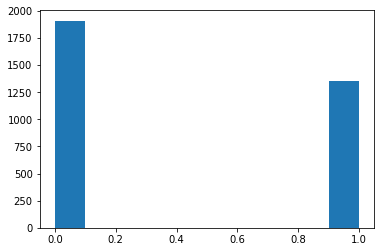

In [0]:
model.eval()
for j in range(data.shape[0]):
    y_pred=model(data[j:j+1,:-1],data[j:j+1,-1])
    predis1=np.append(predis1,y_pred.detach().cpu().numpy())
print("threshold is:",max_threshold)
predis2=np.where(predis1 > max_threshold, 1, 0)
plt.hist(predis2)
plt.plot()

In [0]:
csv = pd.read_csv('sample_submission.csv')
csv['target']=np.array(predis2).reshape(len(predis2))
csv.to_csv('submission.csv',index=False)